# Part 05: BD-e2 Machine Learning Calibration

Tree-based models have inherent systematic bias that may trastically influence model outcomes. Specifically, these models will never be able to predict the highest and lowest measurements provides in the training dataset. To address this, we will apply a bias correction use the methods outlined by Belitz & Stackelberg, 2021.

https://www.sciencedirect.com/science/article/pii/S1364815221000499

1. Open GEDI csv table
2. Apply ECDF Calibratation
3. Record Duan-Smear Factor


# Important
This section is intended to address systematic bias in tree-based models and/or calculate the bias smearing factor addressed when back transforming log based transformations. If neither of these steps apply you can move to the next section.

# Install Packages

Install python packages that we will need for data exploration and Machine Learning

In [ ]:
from sklearn import model_selection, metrics 
import joblib
import time

# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, root_mean_squared_error
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import silhouette_score, silhouette_samples

from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.stats import linregress
import statsmodels.api as sm

## Load Data
Load Data from Part 04

In [60]:
mX = 'M0' #M3, # M1b
model = 'LightGBM_DART' #LightGBM_DART #CatBoost #LightGBM_DART # RandomForest
studyArea = 'EE_Kenobi'
year01 = 1985
year02 = 2023

transform = 'log' #log
date = '20240204'

noTransform = False
SQRT = False
LOG = True

EDM = True
ROE_Duan = False


mlAlgoPath = f'D:/Argus/BDe2/models/final/{model}'

algo = os.path.join(mlAlgoPath,"finalM0_GEDI_EE_Kenobi_LightGBM_DART_log_20250329.sav")


y_predArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_{transform}_{model}.npy")
y_predTrainArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_train_{transform}_{model}.npy")
y_trainCSV = os.path.join(mlAlgoPath,f"{mX}_y_train_{transform}_{model}.csv")
y_testCSV = os.path.join(mlAlgoPath,f"{mX}_y_test_{transform}_{model}.csv")

X_trainCSV = os.path.join(mlAlgoPath,f"{mX}_X_train_{model}.csv")
X_testCSV = os.path.join(mlAlgoPath,f"{mX}_X_test_{model}.csv")

y_fullCSV = os.path.join(mlAlgoPath,f"{mX}_ydf_{transform}_{model}.csv")
# y_predFullArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_full_{transform}_{model}.npy")

lgbm_model = joblib.load(algo)
# calibrationROE = joblib.load(algoSLR)

y_pred = np.load(y_predArray)
y_pred_train = np.load(y_predTrainArray)
# y_pred_full = np.load(y_predFullArray)

y_train = pd.read_csv(y_trainCSV, index_col=0).squeeze()
y_test = pd.read_csv(y_testCSV, index_col=0).squeeze()
# y_full = pd.read_csv(y_fullCSV, index_col=0).squeeze()

## Load X Train
X_train = pd.read_csv(X_trainCSV, index_col=0)
X_test = pd.read_csv(X_testCSV, index_col=0)
                           

# Prepare Empiracal Distribution Matching
https://stackoverflow.com/questions/44132543/python-inverse-empirical-cumulative-distribution-function-ecdf


In [6]:
y_train_EDM = ECDF(y_train)
y_pred_EDM_lgbm = ECDF(y_pred) #y_pred_xgb_final, y_pred

In [87]:
print("y train max Value:",np.max(y_train))
print("y pred max Value:",np.max(y_pred))

print('Difference:',(np.max(y_train)-np.max(y_pred)))
print('% Difference:',((np.max(y_train)-np.max(y_pred))/(np.max(y_train)))*100)

y train max Value: 6.84587987526405
y pred max Value: 6.430022958893016
Difference: 0.41585691637103395
% Difference: 6.074557601772031


In [ ]:
yC = y_train_EDM.y[y_train_EDM.y<=y_train_EDM(np.max(y_pred))]
yC = yC[yC>y_train_EDM(np.min(y_pred))] 

yxc = y_train_EDM.x[y_train_EDM.x<=np.max(y_pred)]
yxc = yxc[yxc>=np.min(y_pred)]

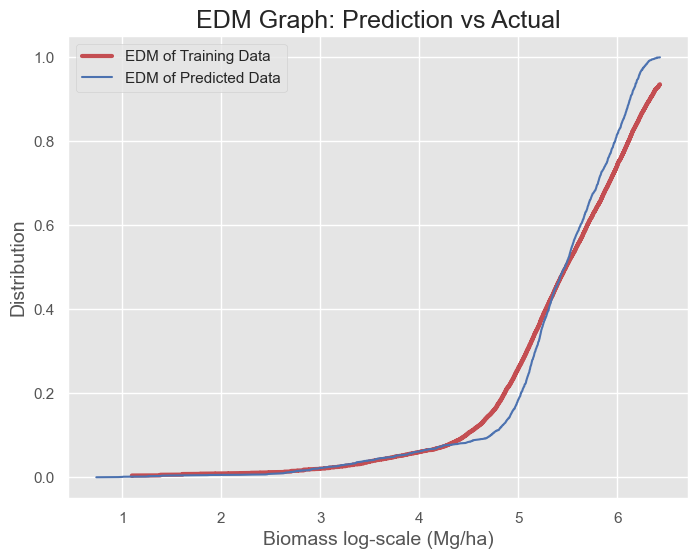

In [11]:
with plt.style.context("ggplot"):
    plt.rcParams["axes.grid"] = True

    plt.plot(yxc, yC, 'r', label = "EDM of Training Data" , linewidth = 3)
    plt.plot(y_pred_EDM_lgbm.x, y_pred_EDM_lgbm.y, 'b', label = "EDM of Predicted Data")
    # plt.plot(y_train_EDM2.x, y_train_EDM2.y, 'g', label = "TRain 2" )


    plt.title("EDM Graph: Prediction vs Actual", fontsize=18)
    plt.xlabel("Biomass log-scale (Mg/ha)", fontsize=14)
    plt.ylabel("Distribution", fontsize=14)


    plt.legend()
    plt.show()

f(x): y=0.7561x+1.2859


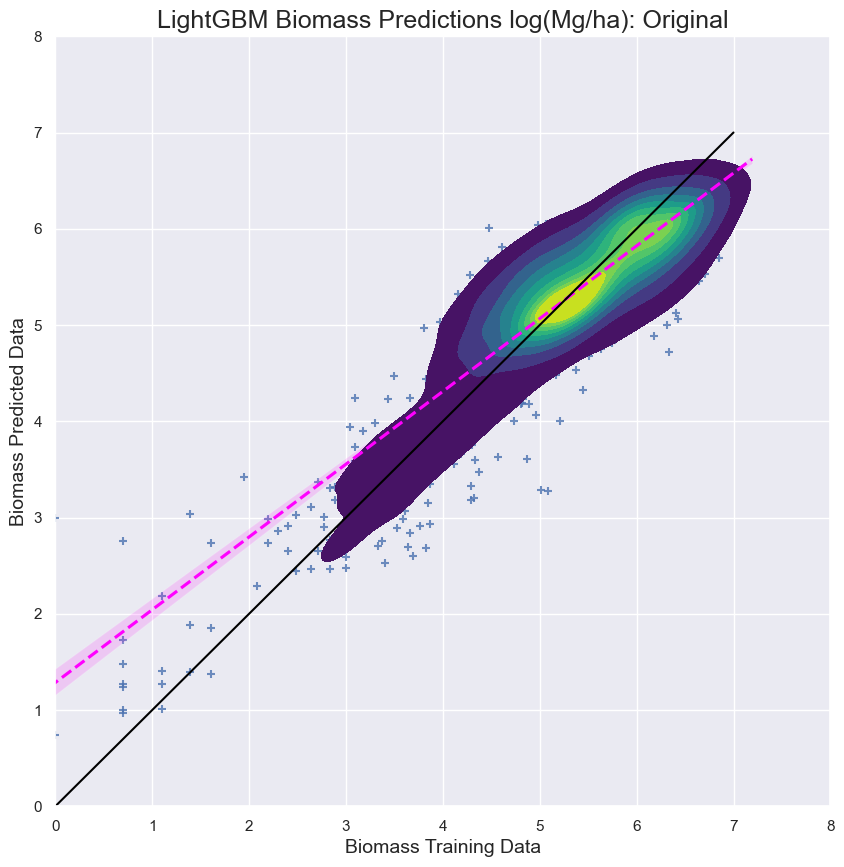

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
q = sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "fuchsia",
                                                                "linestyle":"--"})
sns.kdeplot(x=y_test,y=y_pred,fill=True, cmap="viridis") #mako

plt.plot([0, 8], [0, 8], color="black")
plt.title("LightGBM Biomass Predictions log(Mg/ha): Original", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.xlim(0,8)
plt.ylim(0,8)

#Get Linear Equation:
slope, intercept, r, p, sterr = scipy.stats.linregress(x=q.get_lines()[0].get_xdata(),
                                                      y = q.get_lines()[0].get_ydata())

print(f"f(x): y={round(slope,4)}x+{round(intercept,4)}")

In [ ]:
slope_changes = sorted(set(yxc))

sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes,slope_changes, fill_value="extrapolate", kind="linear")#fill_value="extrapolate") #fill_value="extrapolate"

Y_NEW_Pred_EDM_lgbm = inverted_edf(y_pred_EDM_lgbm(y_pred)) #y_pred_xgb_final / y_pred
y_pred_corrected_lgbm = ECDF(Y_NEW_Pred_EDM_lgbm)

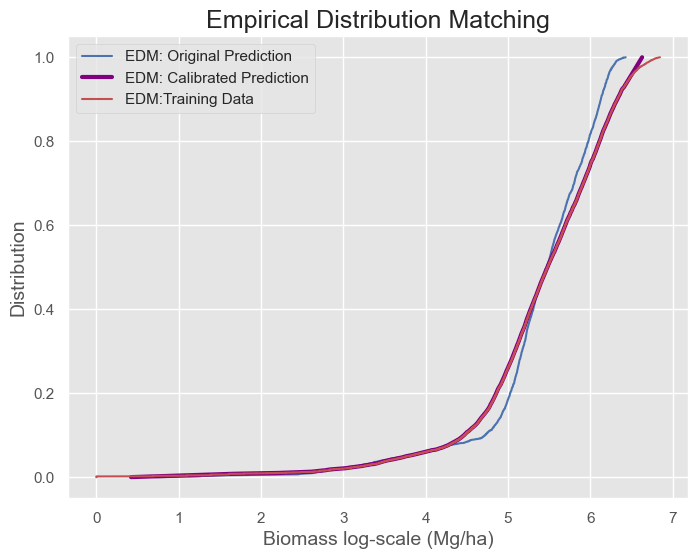

In [21]:
# plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
with plt.style.context("ggplot"):
    plt.rcParams["axes.grid"] = True



    plt.plot(y_pred_EDM_lgbm.x, y_pred_EDM_lgbm.y, 'b', label = "EDM: Original Prediction" )
    plt.plot(y_pred_corrected_lgbm.x, y_pred_corrected_lgbm.y, 'purple', linewidth=3, label = "EDM: Calibrated Prediction" )
    plt.plot(y_train_EDM.x, y_train_EDM.y, 'r', label = "EDM:Training Data" )
    plt.title("Empirical Distribution Matching", fontsize=18)
    plt.xlabel("Biomass log-scale (Mg/ha)", fontsize=14)
    plt.ylabel("Distribution", fontsize=14)

    # plt.style.context("seaborn-white")
    # plt.rcParams["axes.grid"] = True
    plt.legend()
    plt.show()

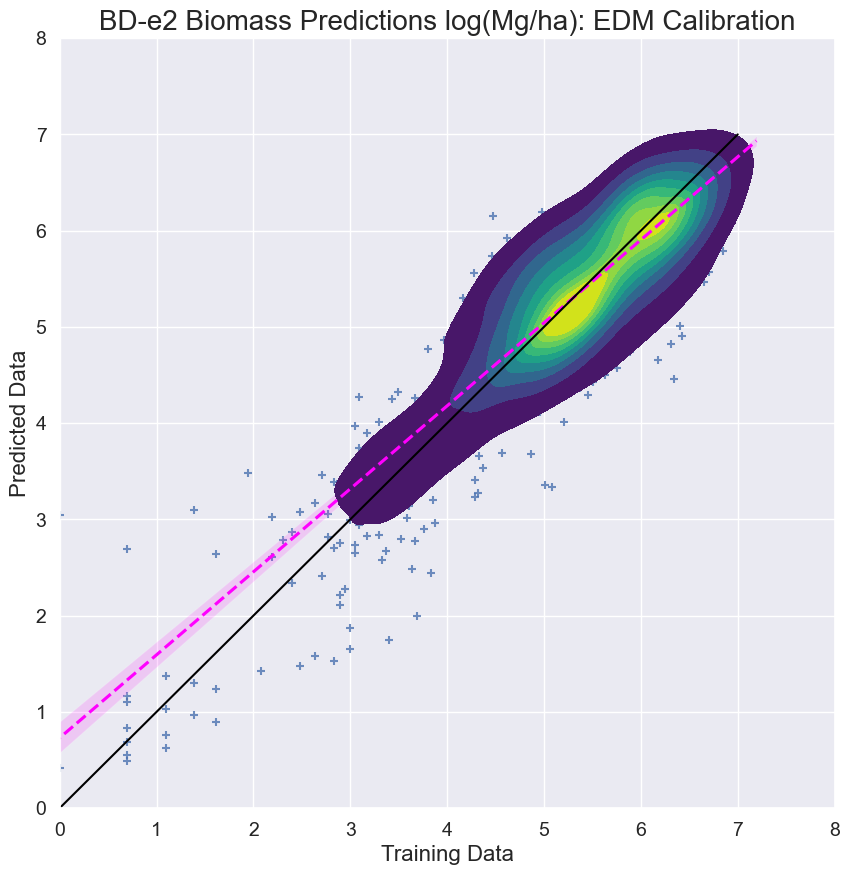

f(x): y=0.8624x+0.7302


In [44]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
q = sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_lgbm,marker="+",truncate=False,line_kws={"color": "fuchsia",
                                                                               "linestyle":"--"})

sns.kdeplot(x=y_test,y=Y_NEW_Pred_EDM_lgbm,fill=True, cmap="viridis") #mako

# color='fuchsia',linestyle='--',lw = 2.5

plt.plot([0, 7], [0, 7], color="black")
# plt.title("LightGBM Biomass Predictions log(Mg/ha): Original", fontsize=18)
# plt.xlabel("Biomass Training Data", fontsize=14)
# plt.ylabel("Biomass Predicted Data", fontsize=14)

# plt.legend(fontsize=14)
plt.title("BD-e2 Biomass Predictions log(Mg/ha): EDM Calibration", fontsize=20)
plt.xlabel("Training Data", fontsize=16)
plt.ylabel("Predicted Data", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

#Get Linear Equation:
slope, intercept, r, p, sterr = scipy.stats.linregress(x=q.get_lines()[0].get_xdata(),
                                                      y = q.get_lines()[0].get_ydata())

print(f"f(x): y={round(slope,4)}x+{round(intercept,4)}")



### Calibrated Results

In [81]:
r_square_lgbm_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_lgbm)
print('R-Square Error associated with LightGBM Regression is:', r_square_lgbm_final)

rmse_lgbm_final = metrics.root_mean_squared_error(y_test, Y_NEW_Pred_EDM_lgbm)
print('RMSE associated with LightGBM Regression is:', rmse_lgbm_final)

mae_lgbm_final = metrics.mean_absolute_error(y_test, Y_NEW_Pred_EDM_lgbm)
print('MAE associated with LightGBM Regression is:', mae_lgbm_final)

R-Square Error associated with LightGBM Regression is: 0.7430019951731264
RMSE associated with LightGBM Regression is: 0.447049680033176
MAE associated with LightGBM Regression is: 0.3503586537445175


### Calculate Duan Smearing Factor
A bias factor is required when back calculating log transformations to there original value. We will calculate the Duan Smearing Factor

In [50]:
residual = y_test - y_pred

In [51]:
smearFactor = np.mean(np.exp(residual))
smearFactor

1.1262235803216032

In [54]:
duanFactor = np.exp(0.5*residual.var())
duanFactor

1.0943163449647513

### Calculate ROE Duan Factors
We will use the Regression of Observed on Estimate Values (ROE) Bias factor calibration in back transforming our data from log base to true values.

Note: There are numerous techiniques that can be used to account for log-based biased in back transforming datasets. The combination of ECDF Match and ROE proved to be the best result.

In [ ]:
y_predROE = lgbm_model.predict(X_train) # X_test_filtered # X_test

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5564150777078827, colsample_bytree=0.4308873788725401 will be ignored. Current value: feature_fraction=0.5564150777078827
[LightGBM] [Warning] lambda_l1 is set=0.00021035468371501475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021035468371501475
[LightGBM] [Warning] lambda_l2 is set=1.7730417457318156e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7730417457318156e-07
[LightGBM] [Warning] bagging_fraction is set=0.9229539669792365, subsample=0.6572447386837766 will be ignored. Current value: bagging_fraction=0.9229539669792365
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [71]:
y_pred_rshp = y_predROE.reshape(-1,1)
y_train_rshp = y_train.to_numpy().reshape(-1,1)
y_pred_xgb_final_rshp = y_pred.reshape(-1,1)

In [76]:
import statsmodels.api as sm
OLS_model_roe = sm.OLS(y_train_rshp,y_pred_rshp).fit()  # training the model
y_roe = OLS_model_roe.predict(y_pred_xgb_final_rshp)  # predicted values
residual_values = OLS_model_roe.resid # residual values

print('Mean of residual errors='+str(OLS_model_roe.resid.mean()))
print('Variance of residual errors='+str(OLS_model_roe.resid.var()))

Mean of residual errors=-0.0067620037726564474
Variance of residual errors=0.07713739214518664


In [77]:
DuanSmearing = np.exp(0.5*(OLS_model_roe.resid.var()))
DuanSmearing

1.0393221232537084

# Save Duan Smearing Factor
Save the ROE Duan Smearing Factor as a TXT to be used in Deployment

In [78]:
algo = 'LightGBM_DART'
date = '20250330'
# Saving the number
def save_number(number, filename="number_data.txt"):
    with open(filename, "w") as file:
        file.write(str(number) + "\n")
        
outDir = f"D:/Argus/BDe2/models/final/{algo}"
outTXTName = f"{algo}_DuanROE_factor_{date}.txt"
outPathTXT = os.path.join(outDir,outTXTName)
save_number(DuanSmearing,outPathTXT)

# Section 05 Complete: 
Move to Section 06 Model Deployment